In [266]:
#database imports
from snowexsql.db import get_db
from snowexsql.data import PointData, LayerData, ImageData, SiteData
from snowexsql.conversions import query_to_geopandas

import rasterio as rio
import rioxarray as rxa
import os
from os.path import join, expanduser, exists
from glob import glob
import numpy as np
import pandas as pd
import pickle
from datetime import date, datetime
from ulmo_extract import get_snotel_within_image
from uavsar_pytools.georeference import reproject_clip_mask
from uavsar_pytools.snow_depth_inversion import depth_from_phase
from scipy.ndimage import gaussian_filter

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
# Import the connection function from the snowexsql library
from snowexsql.db import get_db

# This is what you will use for all of hackweek to access the db
db_name = 'snow:hackweek@db.snowexdata.org/snowex'

# Using the function get_db, we receive 2 ways to interact with the database
engine, session = get_db(db_name)

In [4]:
from snowexsql.data import LayerData, PointData, ImageData, SiteData

In [86]:
# Its convenient to store a query like the following 
qry = session.query(PointData)

# Then filter on it to date
qry = qry.filter(PointData.date >= date(2020, 2, 11))
qry = qry.filter(PointData.date <= date(2020, 2, 13))
qry = qry.limit(5000)
df_feb_12 = query_to_geopandas(qry, engine)

In [ ]:
# Its convenient to store a query like the following 
qry = session.query(PointData)

In [89]:
# Its convenient to store a query like the following 
qry = session.query(PointData)

# Then filter on it to date
qry = qry.filter(PointData.date >= date(2020, 2, 11))
qry = qry.filter(PointData.date <= date(2020, 2, 13))
# filter to depths
qry = qry.filter(PointData.type == 'depth')
# protect ourselves from a lot of data
qry = qry.limit(5000)

# Execute the query and convert to geopandas in one handy function
df_feb_12 = query_to_geopandas(qry, engine)

# Its convenient to store a query like the following 
qry = session.query(PointData)
# Then filter on it to date
qry = qry.filter(PointData.date >= date(2020, 1, 31))
qry = qry.filter(PointData.date <= date(2020, 2, 2))
# filter to depths
qry = qry.filter(PointData.type == 'depth')
# protect ourselves from a lot of data
qry = qry.limit(5000)

# Execute the query and convert to geopandas in one handy function
df_feb_1 = query_to_geopandas(qry, engine)

fp = expanduser('~/scratch/data/uavsar/image_fps')
full_fps = pickle.load(open(fp, "rb"))
gm_fps = [dic for dic in full_fps if dic['location'] == 'Grand Mesa, CO']
image_fps = [dic for dic in gm_fps if dic['flight1'].date() == datetime(2020,2,1).date()]
image_fps = [dic for dic in image_fps if dic['flight2'].date() == datetime(2020,2,12).date()]
image_fps = [dic for dic in image_fps if dic['pol'] == 'VV']
assert len(image_fps) == 1
fps = image_fps[0]

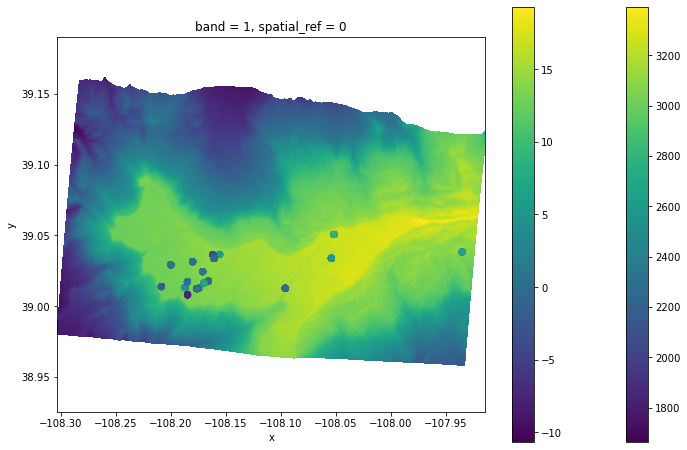

In [92]:
f, ax = plt.subplots(figsize = (12,8))

dem = rxa.open_rasterio(fps['hgt'])
dem.plot(ax = ax)

df_feb_1['geometry'] = df_feb_1.buffer(5)
df_feb_12['geometry'] = df_feb_12.buffer(5)
df_both = df_feb_1.overlay(df_feb_12, how = 'intersection')
df_both = df_both.to_crs(epsg = 4326)
df_both['sd_diff'] = df_both.value_2 - df_both.value_1
df_both.plot(ax = ax, column = 'sd_diff', legend = True)
# ax.set_xlim(-108.1, -108.25)
# ax.set_ylim(39, 39.08)
plt.show()

In [156]:
df = pd.read_csv('/bsuhome/zacharykeskinen/uavsar/data/wx_station/mesa/mesa_snotel.csv', skiprows = 3, index_col=['Date'], parse_dates=['Date'])
snotel_sd_delta = (df[df.index == '2020-02-01']['SNWD.I-1 (in) ']*0.0254).values[0] - (df[df.index == '2020-02-12']['SNWD.I-1 (in) ']*0.0254).values[0]
snotel_coords = (-108.05, 39.05)
with rio.open(fps['fp']) as src:
    for val in src.sample([snotel_coords]): 
        snotel_phase = val
unw = unw - snotel_phase

In [280]:
from astropy.convolution import Gaussian2DKernel
from astropy.convolution import convolve
reproject_clip_mask(fps['inc'], fps['fp'], '/bsuscratch/zacharykeskinen/data/uavsar/inc_repro.tiff')
with rio.open('/bsuscratch/zacharykeskinen/data/uavsar/inc_repro.tiff') as inc:
    dz_arr = depth_from_phase(unw.data[0], inc.read(1), density = 200)
# kernel = Gaussian2DKernel(x_stddev=1)
# dz_arr = convolve(dz_arr, kernel)

#dz_arr = gaussian_filter(dz_arr, 2)
dz = rxa.open_rasterio(fps['fp'])
dz.data = dz_arr.reshape(1, dz_arr.shape[0], dz_arr.shape[1])*100

No permittivity data provided -- calculating permittivity from snow density using method guneriussen2001.


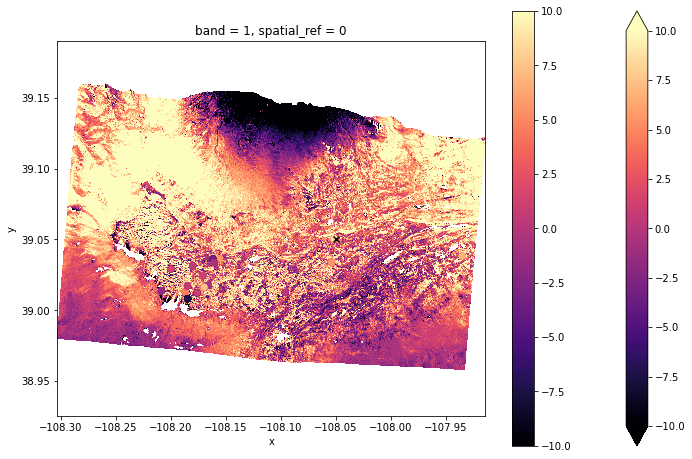

In [274]:
f, ax = plt.subplots(figsize = (12,8))

#dem = rxa.open_rasterio(fps['hgt'])
dz.plot(ax = ax, cmap = 'magma', vmin = -10, vmax = 10)

df_feb_1['geometry'] = df_feb_1.buffer(5)
df_feb_12['geometry'] = df_feb_12.buffer(5)
df_both = df_feb_1.overlay(df_feb_12, how = 'intersection')
df_both = df_both.to_crs(epsg = 4326)
df_both['sd_diff'] = (df_both.value_2 - df_both.value_1)
df_both.plot(ax = ax, column = 'sd_diff', legend = True, cmap = 'magma', vmin = -10, vmax = 10)
ax.scatter(x = snotel_coords[0], y = snotel_coords[1], marker = 'x', color = 'black')
# ax.set_xlim(-108.1, -108.25)
# ax.set_ylim(39, 39.08)
plt.show()

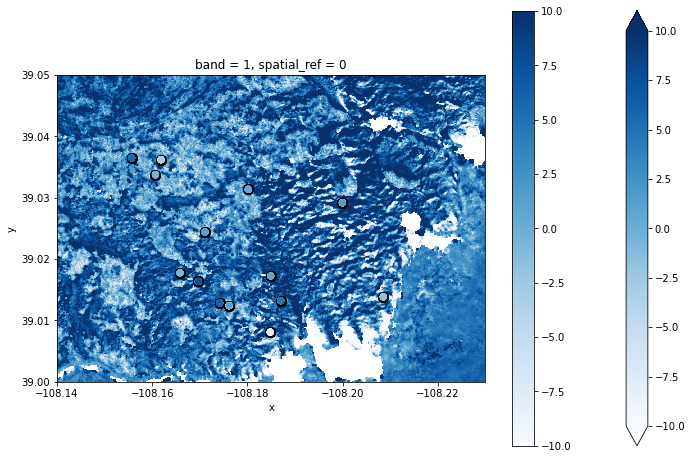

In [275]:
f, ax = plt.subplots(figsize = (12,8))

#dem = rxa.open_rasterio(fps['hgt'])
dz.plot(ax = ax, cmap = 'Blues', vmin =-10, vmax = 10)

df_feb_1['geometry'] = df_feb_1.buffer(5)
df_feb_12['geometry'] = df_feb_12.buffer(5)
df_both = df_feb_1.overlay(df_feb_12, how = 'intersection')
df_both = df_both.to_crs(epsg = 4326)
df_both['sd_diff'] = (df_both.value_2 - df_both.value_1)

df_both.plot(ax = ax, color = 'black', markersize = 90)
df_both.plot(ax = ax, column = 'sd_diff', legend = True, cmap = 'Blues', vmin =-10, vmax = 10)

ax.scatter(x = snotel_coords[0], y = snotel_coords[1], marker = 'x', color = 'black')
ax.set_xlim(-108.14, -108.23)
ax.set_ylim(39, 39.05)
plt.show()

In [281]:
dz.rio.to_raster('/bsuscratch/zacharykeskinen/data/uavsar/gm_phase_dz.tiff')
with rio.open('/bsuscratch/zacharykeskinen/data/uavsar/gm_phase_dz.tiff') as src:
    coord_list = [(x,y) for x,y in zip(df_both['geometry'].x , df_both['geometry'].y)]
    df_both['uavsar_sd'] = [x[0] for x in src.sample(coord_list)]
    df_both.head()

AttributeError: 'PathCollection' object has no property 'xerr'

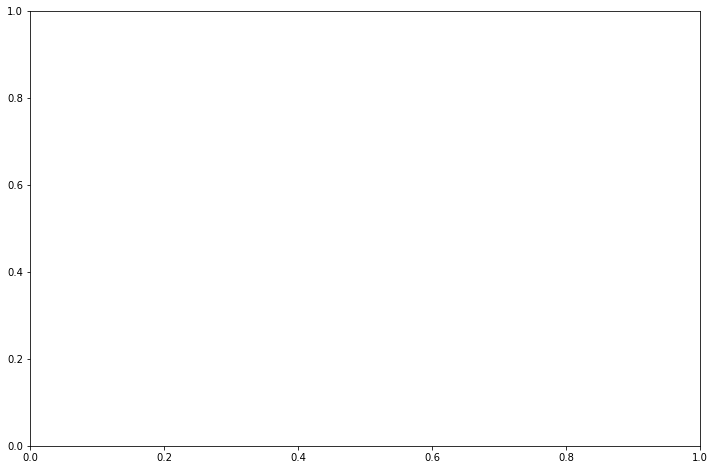

In [296]:
f, ax = plt.subplots(figsize = (12,8))
df_both['geometry-str'] = df_both['geometry'].astype(str)
df_dis = df_both.dissolve('geometry-str', aggfunc = 'mean')
field_sd_std = df_both.dissolve('geometry-str', aggfunc = 'std')['sd_diff'].values
ax.scatter(x = df_dis.sd_diff, y = df_dis.uavsar_sd, xerr = field_sd_std)
lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]

# now plot both limits against eachother
ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
ax.set_aspect('equal')
ax.set_xlim(lims)
ax.set_ylim(lims)


In [294]:
df_both['geometry-str'] = df_both['geometry'].astype(str)
field_sd = df_both.dissolve('geometry-str', aggfunc = 'std')['sd_diff'].values

In [295]:
field_sd

array([2.97039254, 2.63128846, 2.25700181, 2.40077897, 2.17731297,
       2.60912018, 1.92411007, 2.46186089, 2.183087  , 2.5904832 ,
       1.00595377, 1.55309438, 1.92403855, 1.45112365, 2.4091728 ,
       3.67078853, 1.98564412, 4.1809753 , 1.32154418, 1.52152106,
       1.24226232, 1.77514167, 1.76491995, 3.45148259])